In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from scipy.optimize import curve_fit
from scipy import stats
import itertools
from sklearn.metrics import mean_squared_error
from statsmodels.stats.weightstats import DescrStatsW
import astropy.units as u
from scipy.interpolate import interp1d

In [2]:
targets = pd.read_csv('./correct_unassociated/FERMILTRNSUnassociated.csv')

# Collect files
datasets = glob.glob('./correct_unassociated/apjsac*.csv')

# Track SRCNumber
filename = []
filenumber = []

library = {} # key = filename, val = pd.DataFrame
for file in datasets:
    # Read in data for each file
    library[file] = pd.read_csv(file, header=None)
    
    # Track SRCNumber
    filename.append(file)
    filenumber.append( int(file.split('_')[2]) )

# Create pd for file:SRCNumbers
filename_to_filenumber = pd.DataFrame({'filename': filename, 'filenumber': filenumber})

In [3]:
# Merge datasets on IMG file number
targets = targets.merge(right = filename_to_filenumber, how = 'outer', left_on = 'IMG_NUMBER', right_on = 'filenumber')

In [4]:
# Reformat datasets
def reformat_datasets(library):
    reformat = {}

    for key in library:

        # For each dataset
        d = library[key]
        x = []
        y = []
        yerr = []
        # For each row
        for i in range(d.shape[0]):
            # Odds are data, evens are upper/lower error bound
            if i % 2:
                yerr.append(d.iloc[i,1])
            else:
                x.append(d.iloc[i,0])
                y.append(d.iloc[i,1])

        # Make error always positive
        yerr = np.abs(np.array(y) - np.array(yerr))

        # Reformat pd appropriately
        reformat[key] = pd.DataFrame( {'MJD':x, 'Fl (E>100MeV)e-8 cm-2 s-1':y, 'Error':yerr} )

    return reformat

library = reformat_datasets(library)



In [45]:
seconds_in_a_day = 8.64e4

distance_A = lambda A: np.sqrt(3.2 / (A))


invert_distance_to_A = lambda d: 3.2/d**2
#f"{invert_distance_to_A(.3e-1):.1e}"
f"{invert_distance_to_A(1e-6):.1e}"




'3.2e+12'

Running ./correct_unassociated/apjsac072af17_91_hr.csv [1/35]
(norm, T0): [3.         4.03562037], s_err: -1.1286579806655892, s_err/dof: -0.39904085588447674
Running ./correct_unassociated/apjsac072af17_122_hr.csv [3/35]
(norm, T0): [ 7.03027116 11.73945004], s_err: -3.7174688434683394, s_err/dof: -0.7588251500993117
Running ./correct_unassociated/apjsac072af17_13_hr.csv [4/35]
(norm, T0): [3.25151878 4.70778246], s_err: -2.3366936444904836, s_err/dof: -0.8261459607873642
Running ./correct_unassociated/apjsac072af17_62_hr.csv [5/35]
(norm, T0): [3.        4.4266677], s_err: -1.8832990403959193, s_err/dof: -0.3844268068369339
Running ./correct_unassociated/apjsac072af17_130_hr.csv [6/35]
(norm, T0): [12.85183381 22.72416737], s_err: -7.223997970764017, s_err/dof: -2.5540689762025477
Running ./correct_unassociated/apjsac072af17_29_hr.csv [7/35]
(norm, T0): [ 6.21679711 10.45089157], s_err: -3.0976954637613363, s_err/dof: -1.095200734238224
Running ./correct_unassociated/apjsac072af17_25

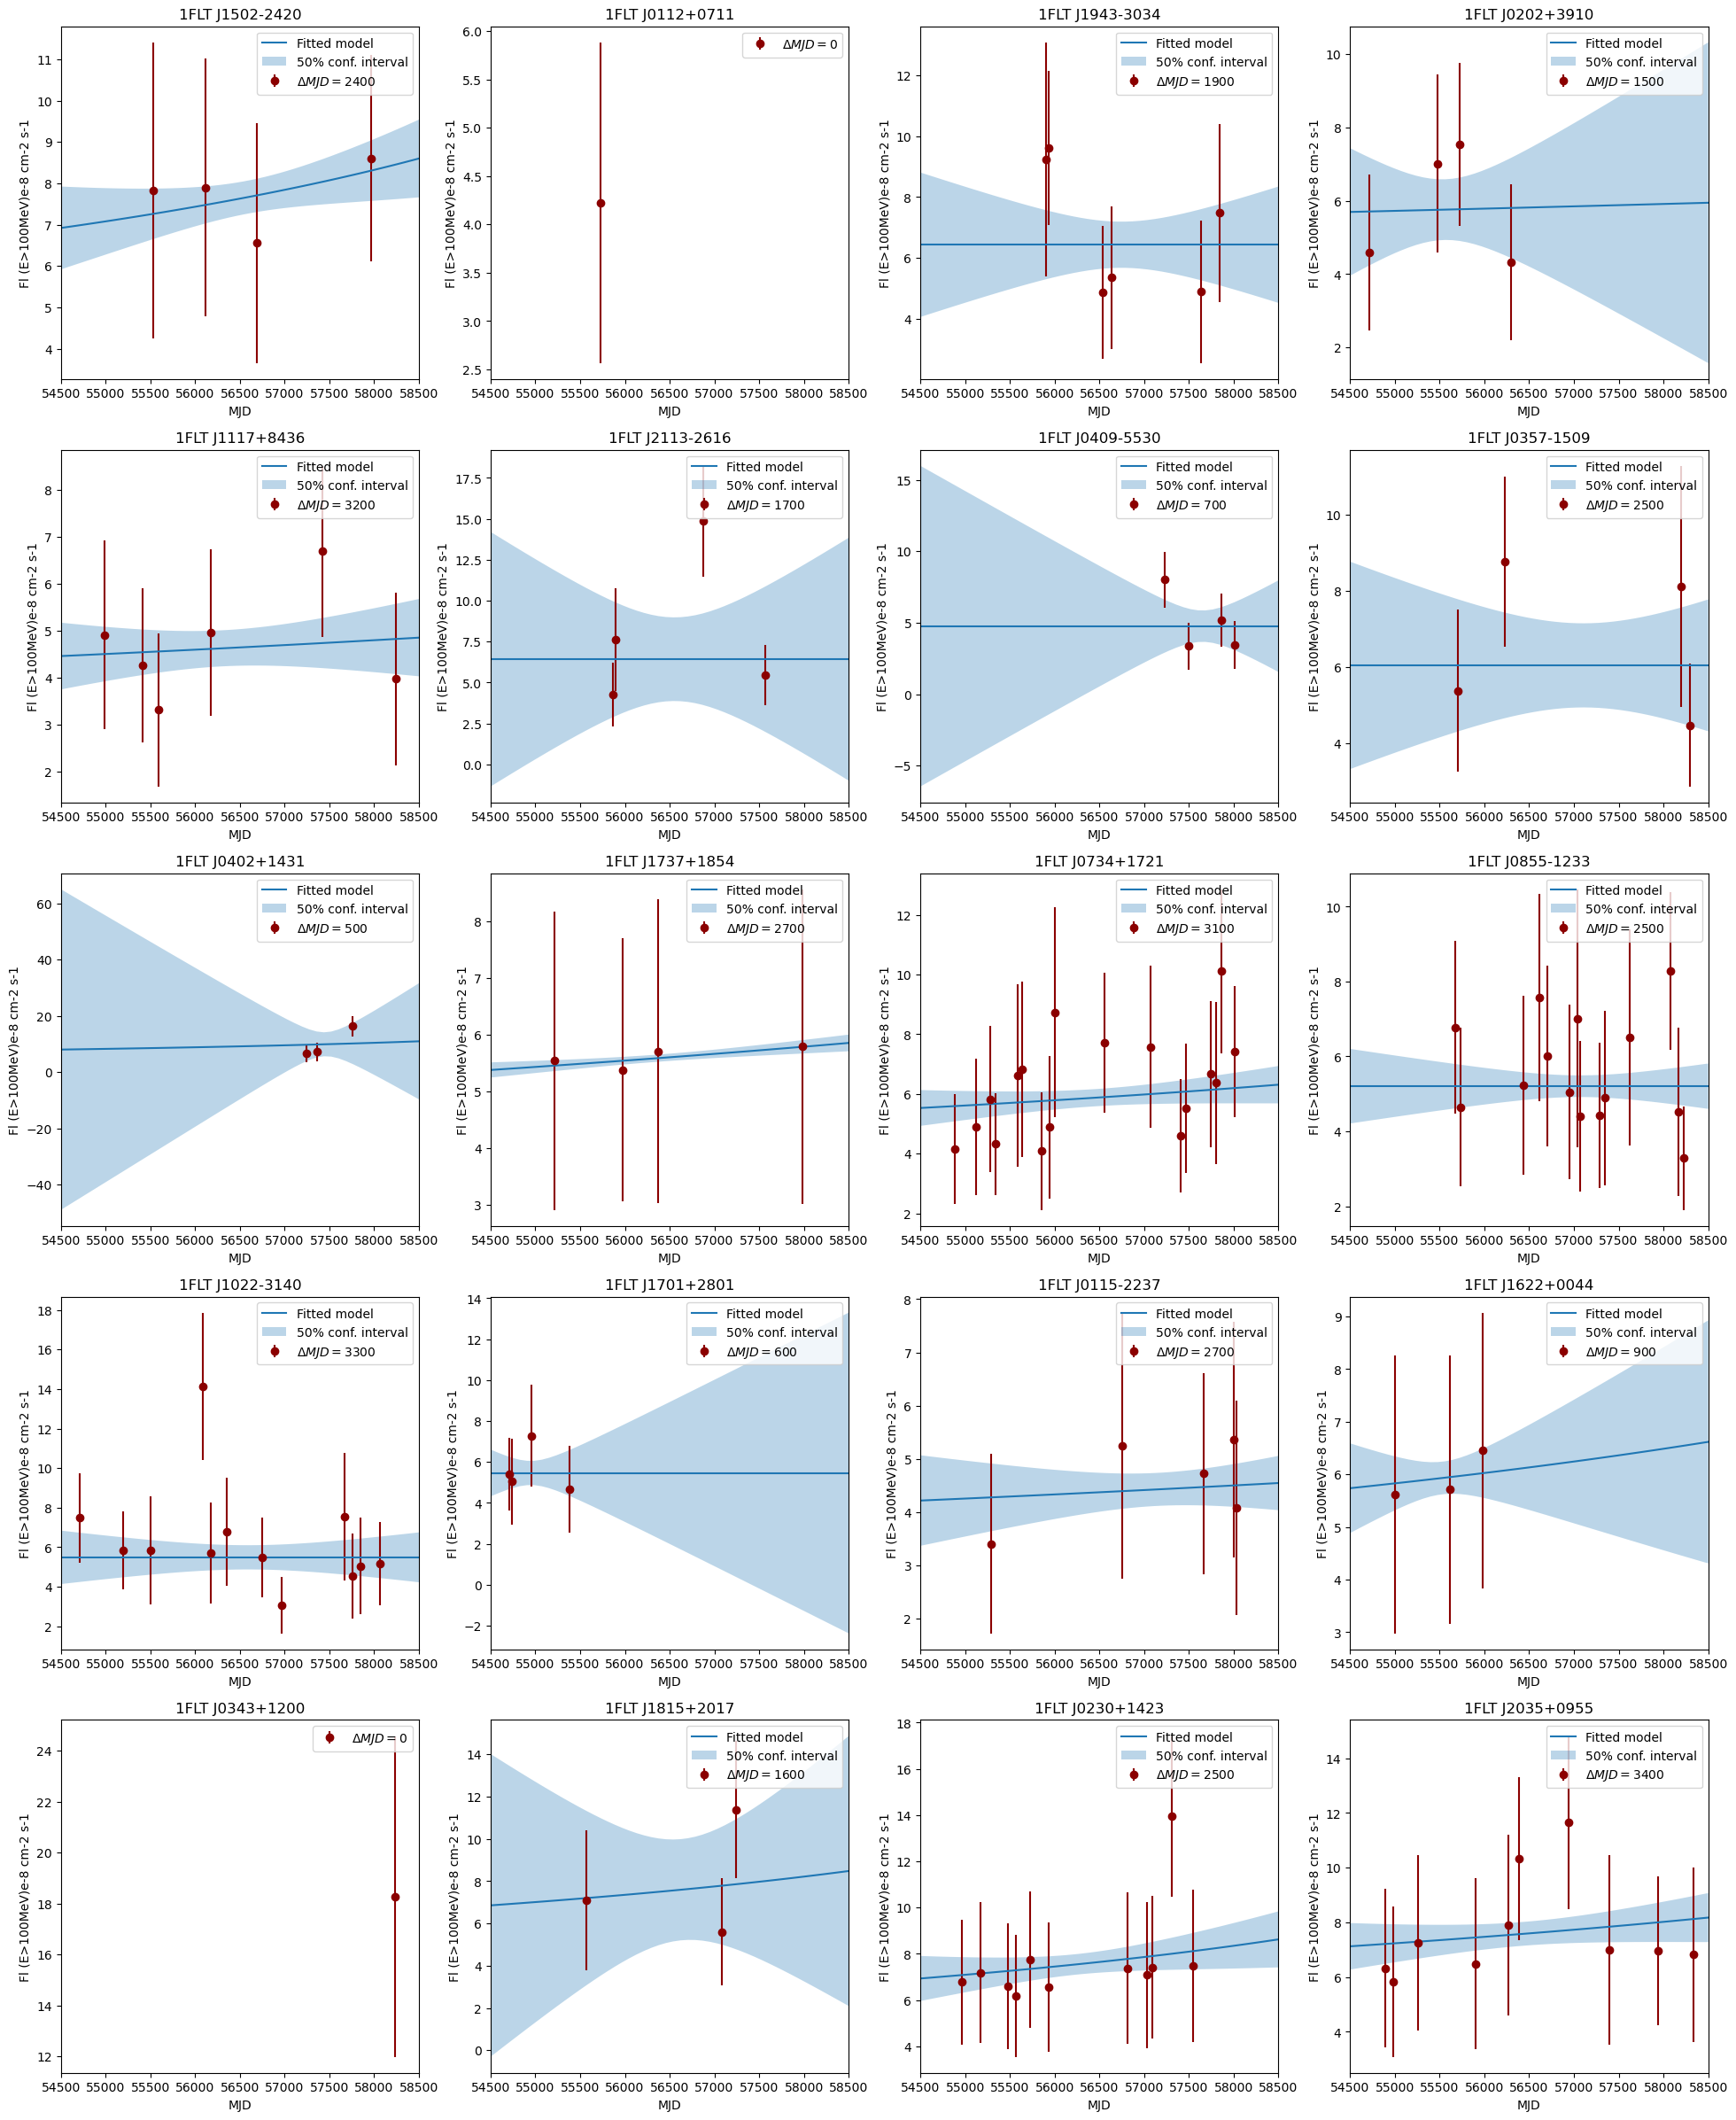

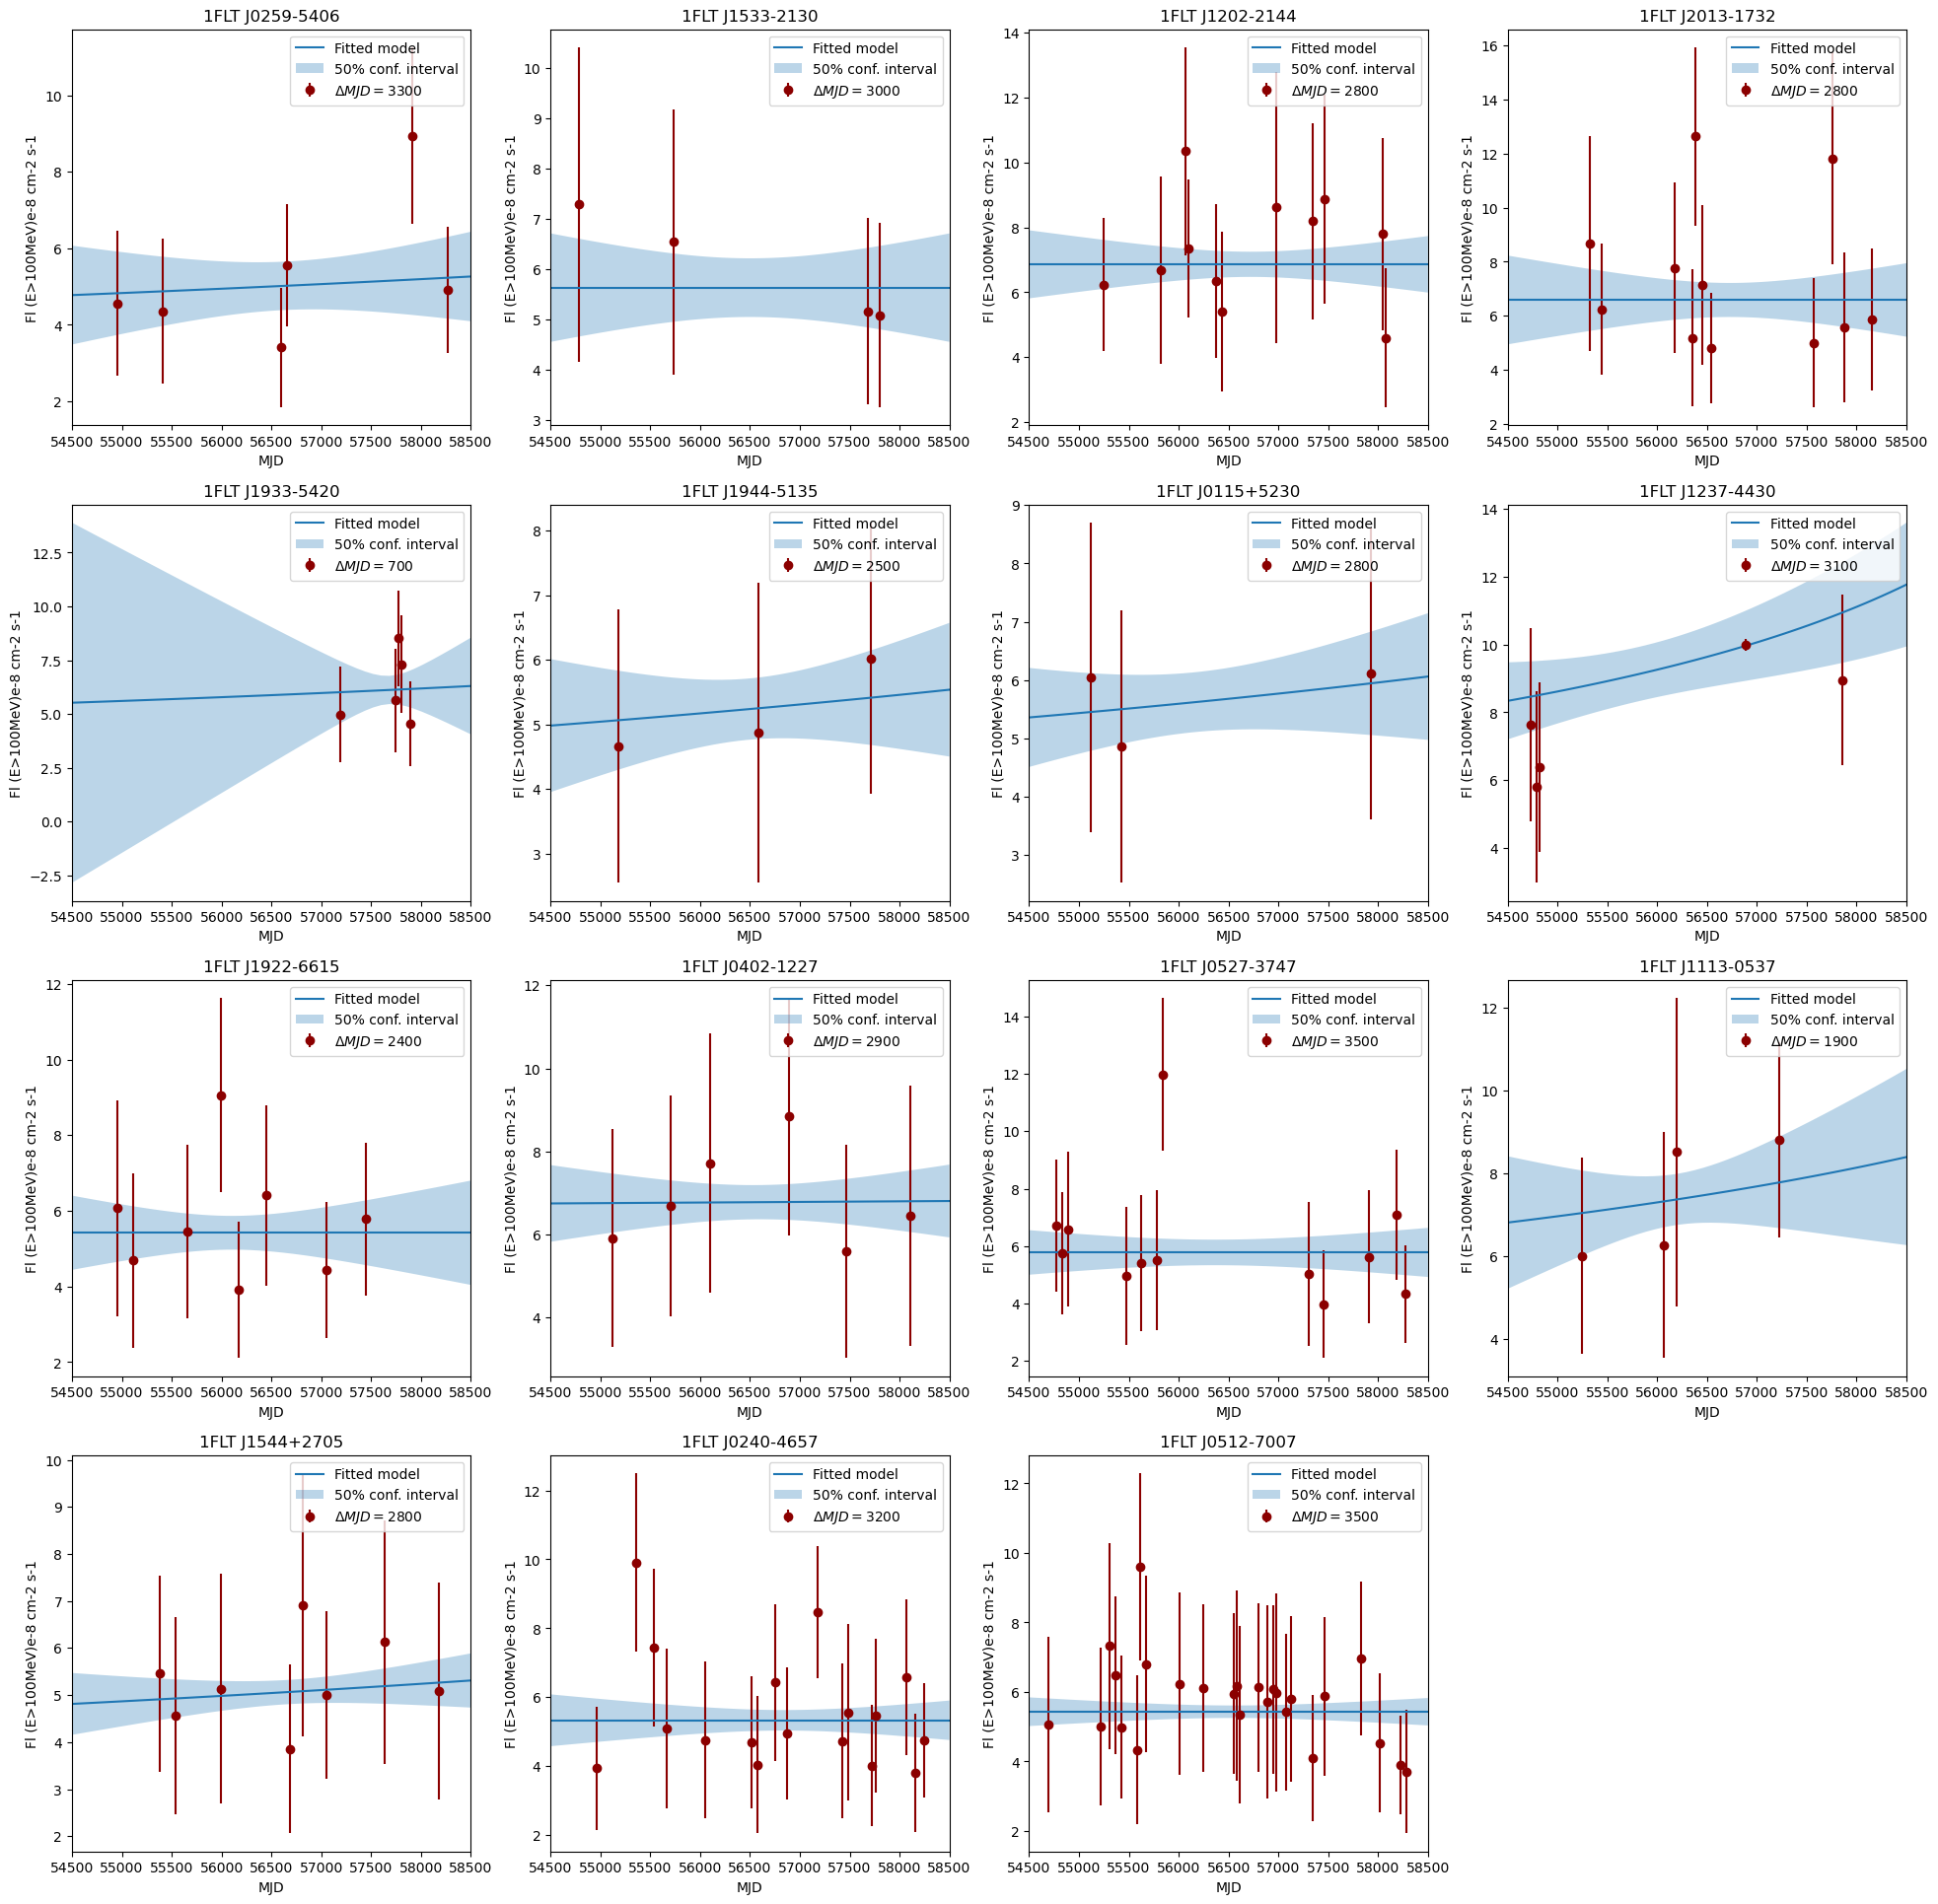

In [43]:
log_model = lambda x,A,T0: 10**A * ((10**T0) - x)**(-.53) # Assume T0 in MJD, so we want seconds


fig1, axes = plt.subplots(5,4, figsize=(24,30))
fig2, axes2 = plt.subplots(4,4, figsize=(24,24))
ax = np.append( axes.flatten(), axes2.flatten() )
# loss_fig, loss_axes = plt.subplots(6,6, figsize=(36,37))
# loss_ax = loss_axes.flatten()

fit_results = {}

ensemble_resolution = 10# 10000 models

for i,key in enumerate(library):

    d = library[key]

    x = d['MJD'].to_numpy()
    y = d['Fl (E>100MeV)e-8 cm-2 s-1'].to_numpy()
    yerr = d['Error'].to_numpy()

    Tobs = int(x[-1] - x[0])
    if Tobs > 0:
        Tobs -= int(str(Tobs)[-2:])

    # Plot datapoints
    ax[i].errorbar(x, y, yerr = yerr, fmt='o', color = 'darkred', label = r'$\Delta MJD = $'+'%s'%Tobs)
    

    # More than 1 datapoint
    if x.shape[0] > 1:

        print(f'Running {key} [{i+1}/{len(library)}]')

        coef_track = []
        loss_track = []
        for T in np.linspace(np.log10(x[-1] - x[0]), 27, ensemble_resolution):
            for d in np.linspace(3, 14, ensemble_resolution):
                try:
                    coefs, cov = curve_fit(f = log_model, xdata = x - x[0], ydata = y, sigma = yerr, 
                        p0 = [
                            d, T
                        ], bounds = (
                            [3, np.log10(x[-1] - x[0])], # lower bounds
                            [14, 27]  # upper bounds
                        )
                    )
                    loss = np.sum(
                        #[ 0 if np.abs(ydata - y[k]) < yerr[k] else (y[k] - ydata)**2 for k,ydata in enumerate(y_model) ]
                        [ 1-stats.norm.pdf(ydata, loc=y[k], scale=yerr[k])  for k,ydata in enumerate(log_model(x - x[0], *coefs)) ]
                    )
                    coef_track.append(coefs)
                    loss_track.append(loss)
                except:
                    print(f'{key}: skipping {d},{T}')
                    pass
        

        # Plot loss
        coef_track = np.array(coef_track)
        # loss_ax[i].scatter(range(len(loss_track)), np.abs(loss_track))
        # loss_ax[i].set_yscale('log')
        # loss_ax[i].set_xscale('log')
        # loss_ax[i].set_xlabel('Seed distance (pc)')
        # loss_ax[i].set_ylabel('Absolute value of loss function')

        # Calculate errors
        # index50 = np.where(
        #     loss_track <= np.quantile(loss_track, 0.5) # loss < 50pctile
        #     )[0]
        # a = coef_track[:,0][index50]
        # a_err = [10**a.min(), 10**a.max()]
        # b = coef_track[:,1][index50]
        # b_err = [10**b.min(), 10**b.max()]
        
        # Calculate best coefs (lowest loss)
        coefs = coef_track[np.where(loss_track == min(loss_track))[0][0]]
        loss = loss_track[np.where(loss_track == min(loss_track))[0][0]]

        # Save results
        # fit_results[key] = (10**coefs, a_err, b_err)

        # Plot best model
        xinterval = np.linspace(54500, 58500) - x[0]
        y_model = log_model( xinterval, *coefs )
        ax[i].plot(xinterval + x[0], y_model, '-', label = 'Fitted model')

        # Calculate confidence interval
        # https://www.scribbr.com/statistics/confidence-interval/
        # https://tomholderness.wordpress.com/2013/01/10/confidence_intervals/
        stds = np.sqrt(np.diagonal(cov))
        n = len(y)
        p = len(coefs)
        dof = max(0, n - p)  # degrees of freedom
        t = stats.t.ppf(.5 / 2., dof) # 50% confidence interval

        s_err = np.sum(np.power(y - log_model(x - x[0], *coefs), 2))
        mean_x = np.mean(x - x[0])
        
        confs = t * np.sqrt(
            ( s_err / dof) * 
            (1.0/ n + 
                (np.power( (xinterval - mean_x) ,2) /
                    ( (np.sum(np.power(x - x[0],2))) - n*(np.power(mean_x,2)) )
                )
            )
            )

        ax[i].fill_between(xinterval + x[0], y_model - np.abs(confs), y_model + np.abs(confs), alpha=0.3, label=r'50% conf. interval')

        print(f'(norm, T0): {coefs}, s_err: {t*np.sqrt(s_err)}, s_err/dof: {t*np.sqrt(s_err/dof/n)}')

        err = np.abs(np.sqrt(s_err) * t)
        fit_results[key] = (10**coefs, 
                            10**np.array([coefs[0] - err, coefs[0] + err]), # a_err
                            10**np.array([coefs[1] - err, coefs[1] + err])) # b_err

        

    ax[i].set_xlim(54500, 58500)

    ax[i].set_xlabel('MJD')
    ax[i].set_ylabel('Fl (E>100MeV)e-8 cm-2 s-1')
    ax[i].set_title(targets.query('filename == @key').iloc[0].NAME[2:-1])
    ax[i].legend()


fig2.delaxes(ax[-1])

# fig.savefig('TransientSourceFits_T0>>DeltaT.png', dpi=500)
# fig.savefig('TransientSourceFits_T0>>DeltaT_lowres.png')
# fig.savefig('TransientSourceFits_logsFit.png')
fig1.savefig('TransientSourceFits_1.png')
fig2.savefig('TransientSourceFits_2.png')


In [50]:
def remaining_mass(T0, 
    alpha = 4 * 1e-4 * (5e14)**2 # g^2 * g / s
    ):
    """
    Input T0 in seconds;
    return mass in grams
    """
    return (3 * alpha * T0)**(1/3) # Eqn. 7 of Nature article

def remaining_time(mass,
    alpha = 4 * 1e-4 * (5e14)**2 # g^2 * g / s)
    ):
    """
    Inverse of last eqn.
    """
    return (mass)**(3) / (3*alpha)

In [51]:
# Unpack results for merging to targets
filenames = []

T0 = []
T0_min = []
T0_max = []

distance = []
distance_min = []
distance_max = []

norm = []
norm_min = []
norm_max = []

for file in fit_results:
    filenames.append(file)

    # Returns as A, T0
    a,b = fit_results[file][0]
    a_err = fit_results[file][1]
    b_err = fit_results[file][2]

    norm.append(a)
    norm_min.append(a_err[0])
    norm_max.append(a_err[1])

    distance.append(distance_A(a))
    distance_min.append(distance_A(a_err[0]))
    distance_max.append(distance_A(a_err[1]))


    T0.append(b)
    T0_min.append(b_err[0])
    T0_max.append(b_err[1])


# Make the df for params
savefile = targets.copy()
savefile = savefile.merge( right = pd.DataFrame({
    'filename': filenames,
    #'T0_error': T0_error,
    #'distance_error': distance_error,
    'T0 (MJD)': T0,
    'T0_min': T0_min,
    'T0_max': T0_max,
    'norm (3.2e-8/pc^2)': norm,
    'norm_min': norm_min,
    'norm_max': norm_max,
    'distance (pc)': distance,
    'dist_min': distance_min,
    'dist_max': distance_max,
}), on='filename', how = 'outer').sort_values('SOURCE_NUMBER')

In [52]:
savefile.to_csv('TransientSources_fitted_params.csv')
savefile

,Unnamed: 0,Unnamed: 0.1,SOURCE_NUMBER,NAME,RA,DEC,LII,BII,SEMI_MAJOR_AXIS,SEMI_MINOR_AXIS,...,filenumber,T0 (MJD),T0_min,T0_max,norm (3.2e-8/pc^2),norm_min,norm_max,distance (pc),dist_min,dist_max
0,3,129,4,b'1FLT J0112+0711',18.210,7.196,132.281,-55.287,27.48,17.46,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4,140,5,b'1FLT J0115+5230',18.858,52.515,126.637,-10.184,13.92,11.22,...,5.0,1.866210e+04,2.408287e+03,1.446148e+05,1.000000e+03,1.290470e+02,7.749116e+03,5.656854e-02,0.157471,2.032118e-02
2,5,119,6,b'1FLT J0115-2237',18.957,-22.630,175.133,-82.872,18.12,15.18,...,6.0,2.947820e+04,1.855811e+03,4.682398e+05,1.000000e+03,6.295536e+01,1.588427e+04,5.656854e-02,0.225454,1.419356e-02
3,12,139,13,b'1FLT J0202+3910',30.599,39.172,137.656,-21.662,35.10,30.96,...,13.0,5.102493e+04,2.350113e+02,1.107838e+07,1.784509e+03,8.219117e+00,3.874471e+05,4.234631e-02,0.623968,2.873881e-03
4,14,132,15,b'1FLT J0230+1423',37.638,14.393,156.053,-42.016,40.32,38.46,...,15.0,1.138481e+04,4.427750e-01,2.927308e+08,1.000000e+03,3.889173e-02,2.571241e+07,5.656854e-02,9.070816,3.527797e-04
5,15,110,16,b'1FLT J0240-4657',40.158,-46.951,262.983,-60.819,37.14,25.38,...,16.0,6.564810e+11,1.158027e+07,3.721566e+16,9.773990e+06,1.724123e+02,5.540838e+11,5.721884e-04,0.136236,2.403185e-06
6,18,108,19,b'1FLT J0259-5406',44.842,-54.103,270.786,-54.292,27.18,26.40,...,19.0,2.346462e+04,1.862728e+01,2.955818e+07,1.000000e+03,7.938452e-01,1.259691e+06,5.656854e-02,2.007738,1.593833e-03
7,22,131,23,b'1FLT J0343+1200',55.757,12.004,175.381,-32.880,27.54,20.10,...,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,24,123,25,b'1FLT J0357-1509',59.404,-15.155,207.223,-45.239,55.38,40.32,...,25.0,7.595223e+11,5.687291e+08,1.014321e+15,1.198096e+07,8.971327e+03,1.600025e+10,5.168079e-04,0.018886,1.414202e-05
9,25,125,26,b'1FLT J0402-1227',60.511,-12.463,204.431,-43.142,32.70,28.26,...,26.0,2.470018e+05,2.377478e+03,2.566159e+07,4.872397e+03,4.689851e+01,5.062048e+05,2.562735e-02,0.261213,2.514270e-03


In [89]:
# From ../Modelling/Analytical_Modelling.ipynb

def logNormalMassFcn(sigma, Mstar, M):
    return np.exp(
        -np.log(M/Mstar)**2 / (2 * sigma**2)
    ) / (np.sqrt(2 * 3.14159) * sigma * M)

fPBH = 1e-8
gramsperGeV = 1 / (5.6095886*1e23)
rhoDM = 0.4 * gramsperGeV * (u.pc.to('cm')**3)

def numberDensity(mass, distance, Mstar = 1e10, sigma = 1):
    return  logNormalMassFcn(sigma, Mstar, mass) * rhoDM * fPBH * 4 / 3 * 3.14159 * distance**3

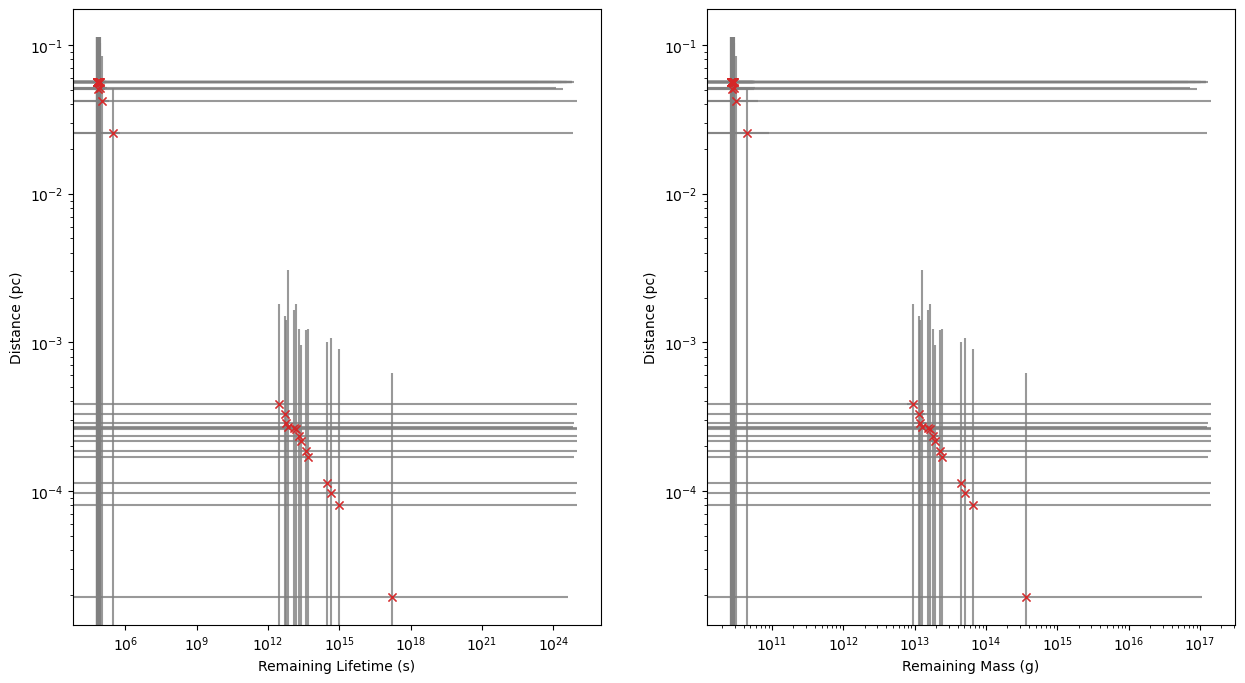

In [90]:
fig, axes = plt.subplots(1,2, figsize = (15,8))

ax = axes[0]
for key in fit_results:
    A, T0 = fit_results[key]['Coefs']
    # A_std, T0_std = np.sqrt(np.diagonal(fit_results[key]['Cov']))
    A_std = T0_std = fit_results[key]['Serr']

    d = distance_A(A)
    d_std = distance_A(A_std)
    ax.errorbar(x = seconds_in_a_day*[T0,T0], xerr = seconds_in_a_day*[ fit_results[key]['T0_min'], fit_results[key]['T0_max'] ],
        y = [d,d], yerr = [ distance_A(fit_results[key]['A_min']), distance_A(fit_results[key]['A_max']) ],
        fmt = 'x', color='grey', markeredgecolor = 'C3', alpha=.8, zorder = 1)
    # ax.plot(T0, d, 'x', color='C3', markeredgecolor = 'C3', alpha=.8, zorder = 1)


# ax.set_xlabel('Norm (1/pc^2)')
ax.set_ylabel('Distance (pc)')
ax.set_xlabel('Remaining Lifetime (s)')
ax.set_yscale('log')
ax.set_xscale('log')

lim = lambda X,Y: (4*3.14159/3) * (3400) / ( X**3 ) / (Y*3e-7)


###########
ax = axes[1]
for key in fit_results:
    A, T0 = fit_results[key]['Coefs']
    # A_std, T0_std = np.sqrt(np.diagonal(fit_results[key]['Cov']))
    A_std = T0_std = 10**fit_results[key]['Serr']

    d = distance_A(A)
    d_std = distance_A(A_std)

    mass = remaining_mass(seconds_in_a_day*T0)
    ax.errorbar(x = [mass,mass], xerr = seconds_in_a_day*[ remaining_mass(fit_results[key]['T0_min']), remaining_mass(fit_results[key]['T0_max']) ], 
        y = [d,d], yerr = [ distance_A(fit_results[key]['A_min']), distance_A(fit_results[key]['A_max']) ], 
        fmt = 'x', color='grey', markeredgecolor = 'C3', alpha=.8, zorder = 1)
    # ax.plot(mass, d, 'x', color='C3', markeredgecolor = 'C3', alpha=.8, zorder = 1)

ax.set_ylabel('Distance (pc)')
ax.set_xlabel('Remaining Mass (g)')
ax.set_yscale('log')
ax.set_xscale('log')


fig.savefig('TransientsDistribution.png')